In [1]:
import wandb, torch
from ddpm_conditional import *
from fastcore.all import *

In [2]:
# use the best model to generate samples
model_artifact = '945096249-sjtu-hpc-center/train_sd/model:v2'
run = wandb.init()
artifact = run.use_artifact(model_artifact, type='model')
artifact_dir = artifact.download()


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/estar/.netrc.
wandb: Currently logged in as: 945096249 (945096249-sjtu-hpc-center) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact 'model:v2', 356.31MB. 3 files...
wandb:   3 of 3 files downloaded.  
Done. 00:00:00.9 (401.1MB/s)


In [3]:
model_cpkt_path = Path(artifact_dir)

In [4]:
model_cpkt_path

Path('/home/estar/TZ/AI-L/MY_GM/Diffusion-Models-Train/artifacts/model:v2')

In [5]:
diff = Diffusion(img_size=config.img_size, num_classes=config.num_classes)

In [6]:
diff.load(model_cpkt_path)

In [7]:
labels = torch.ones(10).long().cuda()

In [8]:
cifar_labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [10]:
samples = diff.sample(use_ema=False, labels=labels)

02:36:43 - INFO: Sampling 10 new images....


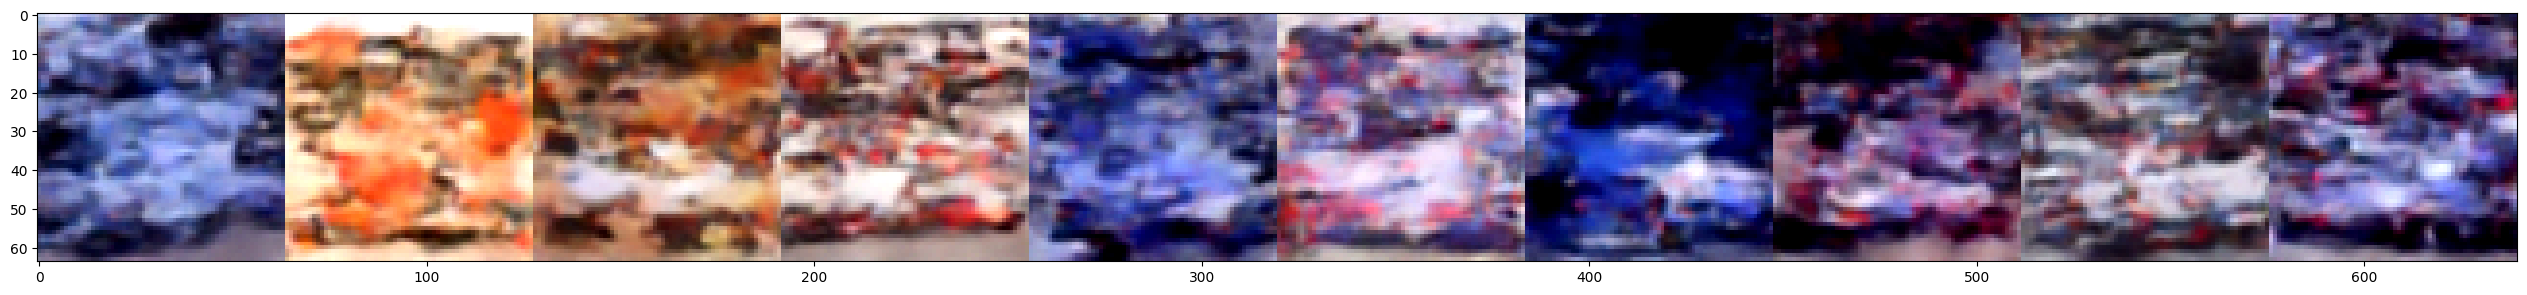

In [11]:
plot_images(samples)

In [12]:
wandb.finish()

In [13]:
import torchvision, math

@patch
@torch.inference_mode()
def sample_intermediate(self:Diffusion, use_ema, labels, cfg_scale=3):
    n = len(labels)
    model = self.ema_model if use_ema else self.model
    model.eval()
    with torch.inference_mode():
        x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
        for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
            t = (torch.ones(n) * i).long().to(self.device)
            predicted_noise = model(x, t, labels)
            if cfg_scale > 0:
                uncond_predicted_noise = model(x, t, None)
                predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

            # --- 修复点：将 batch 转为网格图再上传 wandb ---
            vis = (x.clamp(-1, 1) + 1) / 2  # 0..1
            nrow = int(math.sqrt(n)) if n > 1 else 1
            grid = torchvision.utils.make_grid(vis, nrow=nrow)  # [C,H,W]
            img_np = grid.permute(1, 2, 0).cpu().numpy()
            wandb.log({"gens": wandb.Image(img_np)})

    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)
    return x

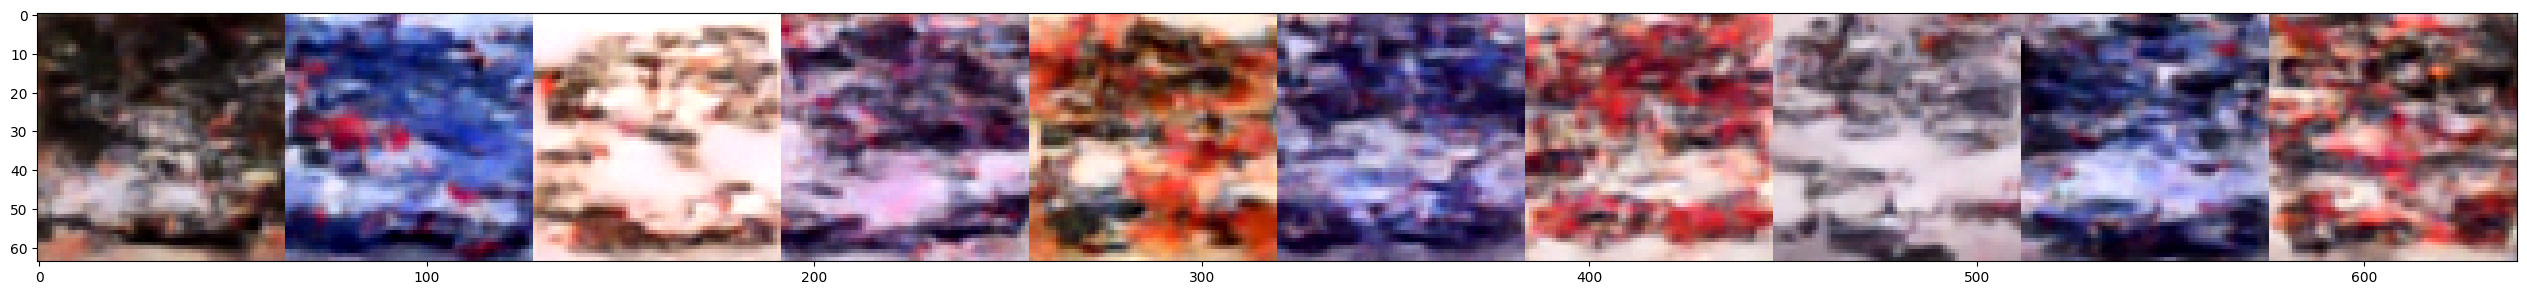

In [14]:
with wandb.init(project="train_sd", job_type="generation", config=config):
    samples = diff.sample_intermediate(True, labels=labels)
    plot_images(samples)

In [15]:
from pathlib import Path, PosixPath
import os
model_cpkt_path = Path(artifact_dir)
print("artifact dir:", model_cpkt_path)
print("listing:", os.listdir(model_cpkt_path))
print("ckpt exists:", os.path.exists(os.path.join(model_cpkt_path, "ckpt.pt")))
print("ema exists:", os.path.exists(os.path.join(model_cpkt_path, "ema_ckpt.pt")))

artifact dir: /home/estar/TZ/AI-L/MY_GM/Diffusion-Models-Train/artifacts/model:v2
listing: ['optim.pt', 'ema_ckpt.pt', 'ckpt.pt']
ckpt exists: True
ema exists: True


In [16]:
from ddpm_conditional import Diffusion, config
import torch

diff = Diffusion(img_size=config.img_size, num_classes=config.num_classes)
def param_sum(m):
    return sum(p.abs().sum().item() for p in m.parameters())

print("before load model param sum:", param_sum(diff.model))
diff.load(model_cpkt_path)   # 你之前运行的那行
print("after load model param sum:", param_sum(diff.model))
print("ema param sum:", param_sum(diff.ema_model))

before load model param sum: 252929.25720594823
after load model param sum: 221462.4500953555
ema param sum: 221470.07526895404
